In [1]:
from fusions.diffusion import Diffusion
from fusions.cfm import CFM
from lsbi.model import MixtureModel
import numpy as np
import anesthetic as ns

# Setup a problem with lsbi

Five dimensional parameter space

In [2]:
dims = 5
data_dims = dims
np.random.seed(12)

mixtures = 5
A = np.random.randn(mixtures, data_dims, dims)
Model = MixtureModel(
    # M=A,
    M=np.stack([np.eye(dims), -np.eye(dims)]),
    mu=np.zeros(dims),
    Sigma=np.eye(dims),
    m=np.zeros(data_dims),
    C=np.eye(data_dims)*0.1,
)

data = Model.evidence().rvs()



draw the posterior in orange and prior in blue

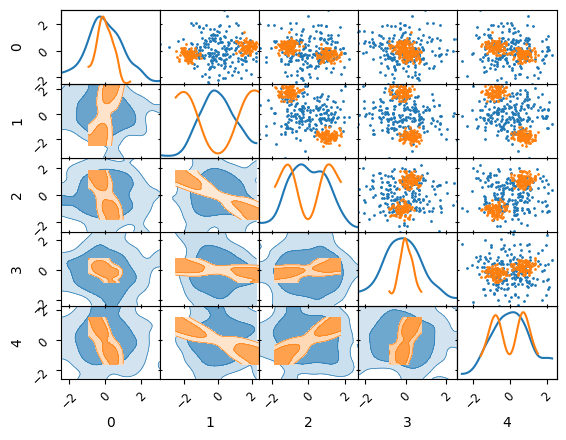

In [3]:
size = 200
P = Model.posterior(data).rvs(size)
theta=Model.prior().rvs(size)
a = ns.MCMCSamples(theta).plot_2d(np.arange(dims))
a= ns.MCMCSamples(P).plot_2d(a)

# Training a diffusion model

Sample from the posterior as training data. Train a Continuous Flow Matching objective

In [4]:
training_data = Model.posterior(data).rvs(size*10)
# diffusion = Diffusion(prior = Model.prior())
diffusion = CFM(prior = Model.prior())

In [5]:
diffusion.train(training_data,n_epochs=1000)

100%|██████████| 1000/1000 [00:02<00:00, 379.75it/s]


Now we can compare how well this trained flow approximates the target

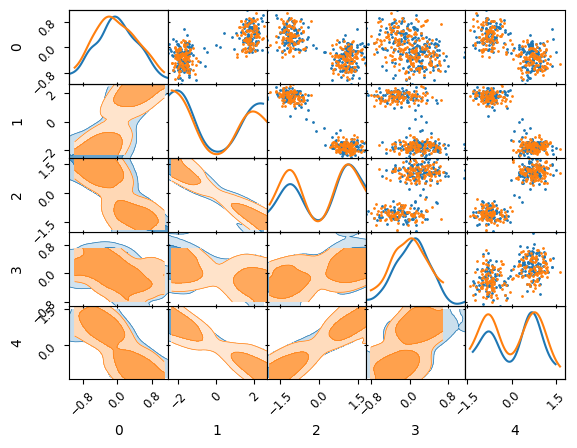

In [6]:
size = 200
P = Model.posterior(data).rvs(size)
theta=diffusion.rvs(size)
a = ns.MCMCSamples(theta).plot_2d(np.arange(dims))
a= ns.MCMCSamples(P).plot_2d(a)

# Trajectories in ODE
Of interest to is in how straight lines drawn in either the prior or a gaussian latent space are mapped to the target.

## As a function of "time"
The forward model that the CFM encodes is a neural ODE, we can track the evolution of this as afunction of the time parameter introduced in training

In [7]:
t=Model.prior().rvs(1000)
x_t =diffusion.predict(t, steps=100)

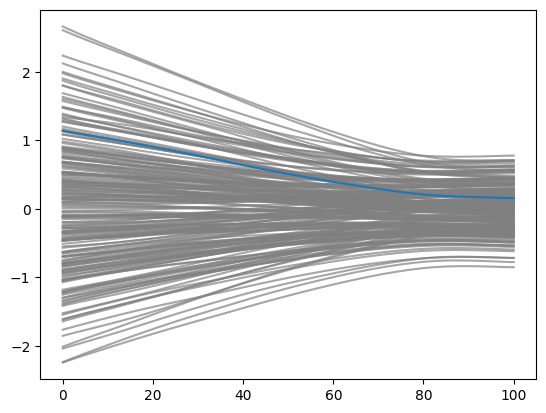

In [8]:
import matplotlib.pyplot as plt
f,a = plt.subplots()
param_idx=3
a.plot(x_t[:199,:,param_idx].T, color="grey", alpha=0.7);
a.plot(x_t[200,:,param_idx], color="C0")

## As a function of path

We can build a set of adjacent points that cuts through our 5d space in a straight line from either
* [-1,-1,-1,-1,-1] to [1,1,1,1,1] 

or

* [-1,0,0,0,0] to [1,1,1,1,1]

and then examine what it looks like after being diffused

In [9]:
line_x = np.linspace(-1,1,50)
line_y=np.zeros((line_x.shape[0], 4))
test_x=np.repeat(line_x[...,None], 5, axis=1)
# test_x=np.concatenate([np.atleast_2d(line_x),line_y.T]).T
target_x=diffusion.predict(test_x, steps=100)

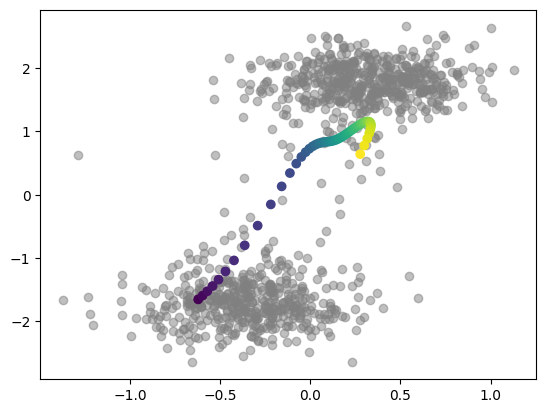

In [10]:
param_idx = 0
plt.scatter(x_t[...,-1,param_idx], x_t[...,-1,param_idx+1], c="grey", alpha=0.5)
plt.scatter(target_x[:,-1,param_idx], target_x[:,-1,param_idx+1], c= np.arange(len(line_x)))


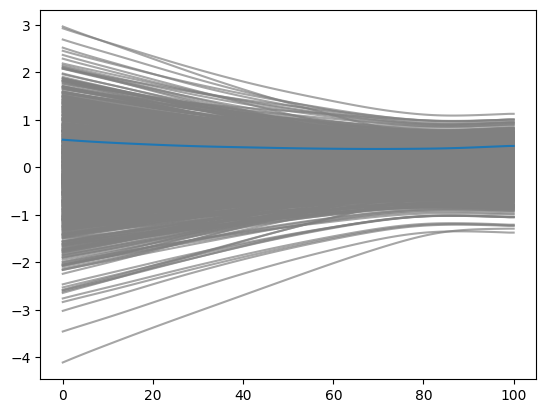

In [11]:
f,a = plt.subplots()
param_idx=0
a.plot(x_t[199:,:,param_idx].T, color="grey", alpha=0.7);
a.plot(x_t[200,:,param_idx], color="C0")

## Computing volumes

In [12]:
target_x, J_approx=diffusion.rvs(jac=True,solution="approx")

TypeError: Model.rvs() missing 1 required positional argument: 'n'

In [ ]:
initial_points = Model.prior().rvs(100)

In [ ]:
target_x, J_approx=diffusion.predict(initial_points,jac=True,solution="approx")

In [ ]:
target_x, J_exact=diffusion.predict(initial_points,jac=True,solution="exact")

In [ ]:
target_x, J_none=diffusion.predict(initial_points,jac=True,solution="none")

In [ ]:
target_x, J_approx=diffusion.predict(initial_points,jac=True,solution="approx")
J_approx

# 1-np.exp(J_exact)

Array([-5.82641860e-06, -1.90592903e-06, -1.40394031e-05, -8.55495364e-06,
       -4.59203739e-06,  1.05913805e-05, -5.11978214e-06, -2.80107116e-07,
       -2.81575717e-06, -7.63493881e-06, -5.18402248e-06, -6.61098511e-07,
       -1.69432351e-05, -7.59151021e-07, -5.46286310e-06, -5.56048190e-06,
       -4.26368388e-06, -1.00745183e-06, -4.07570087e-06, -3.89589832e-06,
       -1.01539524e-06, -6.61937156e-06, -1.94715483e-07, -5.81864060e-06,
       -4.88297155e-06, -3.05934486e-06, -1.75153843e-06, -2.60779461e-06,
       -8.54284372e-06, -8.86420639e-06, -4.11229394e-06,  1.08956647e-06,
       -8.28387056e-06, -4.59419471e-06, -4.99940643e-06, -6.18254444e-06,
       -1.47931257e-06, -7.58831447e-06, -4.17142064e-06, -2.66008783e-06,
       -3.83940778e-06, -5.80778669e-06, -5.14879275e-06, -3.84747682e-06,
       -1.10751234e-05, -1.00613788e-05, -8.91184118e-06, -9.20399634e-06,
       -6.18099511e-06, -2.99780436e-06, -8.40552548e-06, -4.79353457e-06,
       -7.92666742e-06, -

In [ ]:
ns.MCMCSamples(target_x,weights=np.exp(np.asarray(J_approx))).compress().shape


(100, 5)